## Install Packages

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from tensorflow import Tensor
print("Tensorflow version is ", tf.__version__)
print('Keras version      : ',keras.__version__)
import numpy as np
import os, sys
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import h5py as h5
from sklearn.metrics import classification_report, confusion_matrix
import random
import time
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import  Dropout, Activation, GlobalAveragePooling1D, ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD, Adadelta
from tensorflow.keras.layers import Reshape, Dense, Flatten, Add
from tensorflow.keras.activations import relu
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, History
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential

from random import shuffle
import glob
from sklearn.model_selection import train_test_split
from pathlib import Path
import pickle
from progressbar import ProgressBar
import matplotlib.pyplot as plt

Tensorflow version is  2.6.0
Keras version      :  2.6.0


## Download the 2021 Dataset from Deepsig
Deepsig has released multiple RF data sets, we are using the 2021 INT8 dataset.

This data set contains RF data with 27 different modulations at various SNR. Each of the 2875392 data inputs is 1024 samples long of complex (I Q) data.

You need to register  with Deepsig in order to download the dataset, go to 
https://opendata.deepsig.io/datasets/2021.07/RADIOML_2021_07_INT8.tar.gz, and register. After you download the file, and copy it to the same directory containing this Jupyter notebook 

In [2]:
!tar -xvf RADIOML_2021_07_INT8.tar.gz
!ls RADIOML_2021_07_INT8/

RADIOML_2021_07_INT8/
RADIOML_2021_07_INT8/LICENSE.TXT
RADIOML_2021_07_INT8/classes.py
RADIOML_2021_07_INT8/RADIOML_2021_07_INT8.hdf5
classes.py  LICENSE.TXT  RADIOML_2021_07_INT8.hdf5


## 2018 Dataset 

### Read in RF Data
3 Arrays will be created. <br>
myData holds the 1024 I and Q time values for each input sample. <br>
myMods holds the one hot encoded RF class for each sample.<br>
mySNRs holds the SNR value for each sample.<br>



In [3]:
#Note this is needed to aviod a tensorFlow memory issue
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

data_file = '/workspace/files/RADIOML_2021_07_INT8/RADIOML_2021_07_INT8.hdf5'
file_handle = h5.File(data_file,'r+')

myData = file_handle['X'][:]  #1024x2 samples 
myMods = file_handle['Y'][:]  #mods 
mySNRs = file_handle['Z'][:]  #snrs  

print(np.shape(myData))
print(np.shape(myMods))
print(np.shape(mySNRs))
file_handle.close()

np.random.seed(0)

(2875392, 1024, 2)
(2875392, 27)
(2875392, 1)


### List the SNRs


In [4]:
snrs = list(np.unique(mySNRs.T[0]))  
print(snrs)

[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]


### Define the Modulaton classes

In [5]:
mods = ["OOK","4ASK","8ASK",
        "BPSK","QPSK","8PSK","16PSK","32PSK",
        "16APSK","32APSK","64APSK","128APSK",
        "16QAM","32QAM","64QAM","128QAM","256QAM",
        "AM-SSB-WC","AM-SSB-SC","AM-DSB-WC","AM-DSB-SC","FM",
        "GMSK","OQPSK","BFSK","4FSK","8FSK"]

num_classes = np.shape(mods)[0]
print("The number of classes is ", num_classes)


The number of classes is  27


### Examine RF input samples
The samples in data set are ordered by class, let's print out one example from each class.

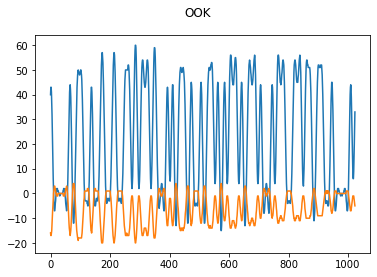

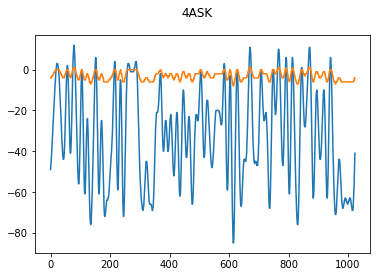

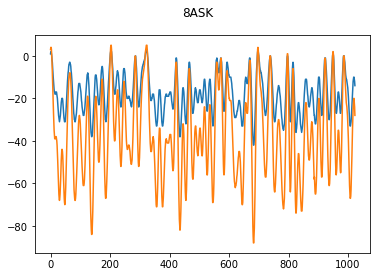

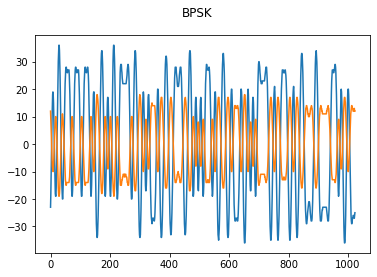

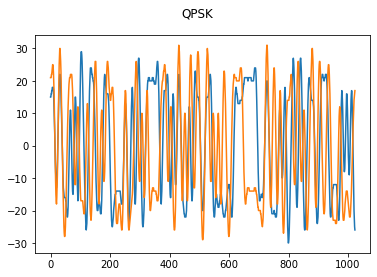

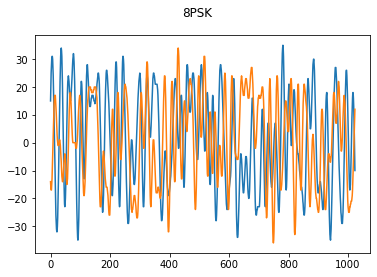

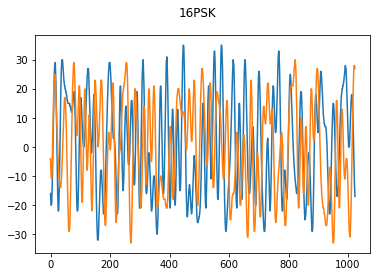

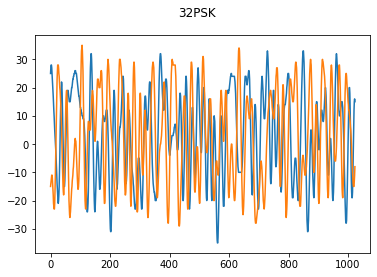

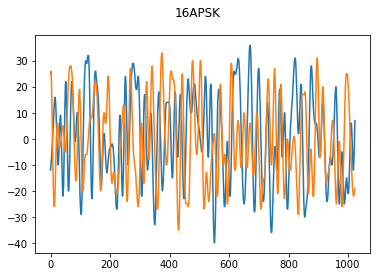

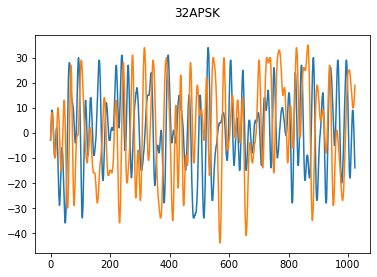

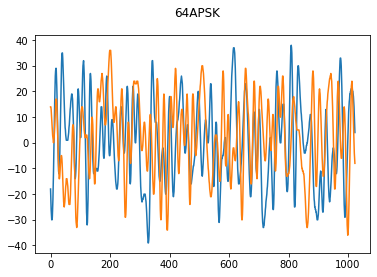

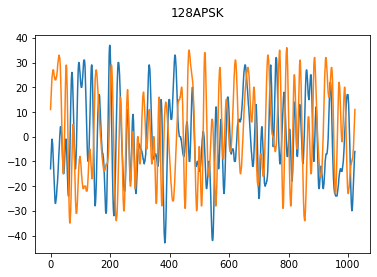

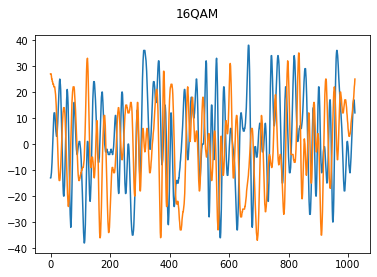

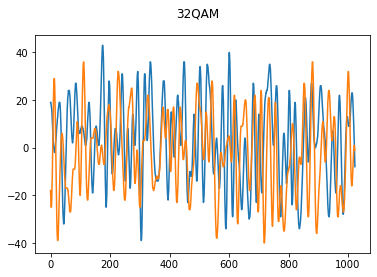

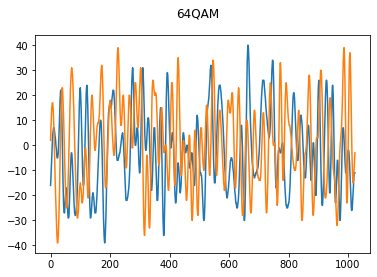

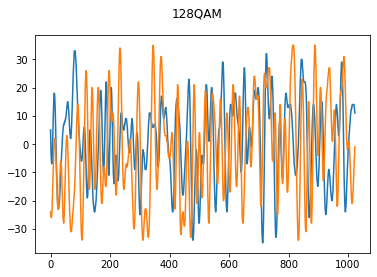

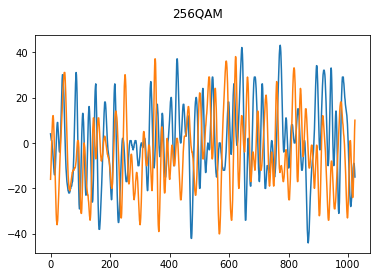

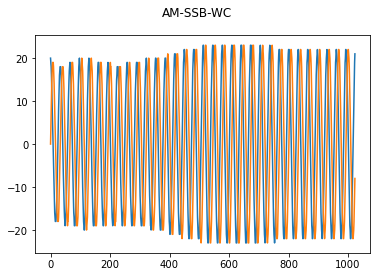

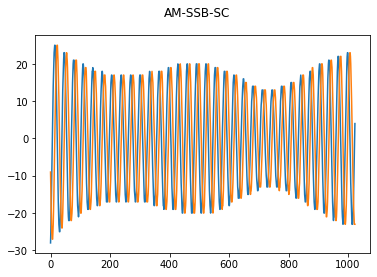

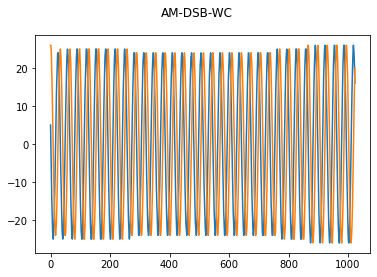

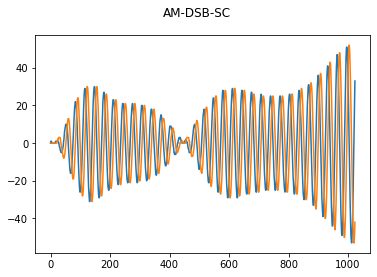

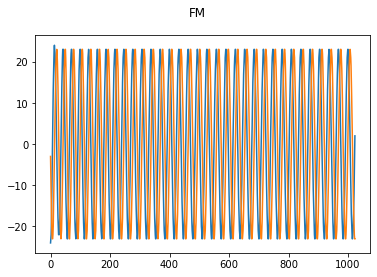

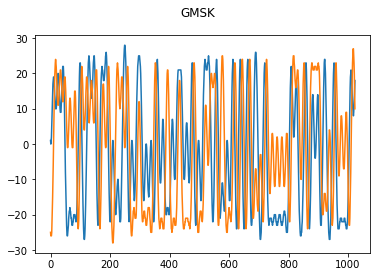

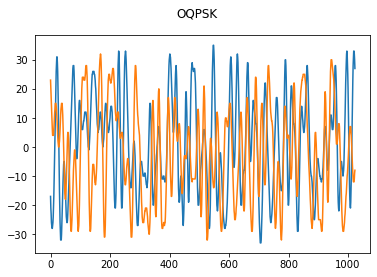

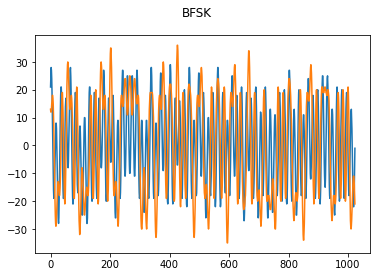

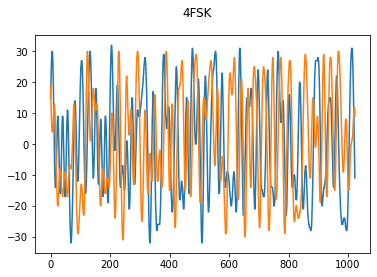

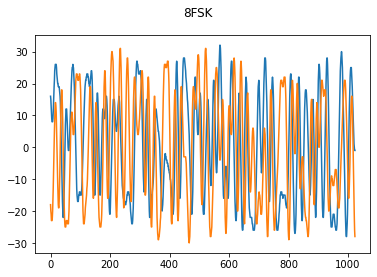

In [6]:
#turn off warning about more than 10 figures plotted
plt.rcParams.update({'figure.max_open_warning': 0})

def my_range(start, end, step):
    while start <= end:
        yield start
        start += step

size = np.size(myData, axis = 0)
step = size//27

for x in my_range(100000, (size-1), step):
  plt.figure()
  plt.suptitle( mods[np.argmax(myMods[x])])
  plt.plot(myData[x,:,0])
  plt.plot(myData[x,:,1])

### Reshape RF data to 2D Matrix
We will reshape both the I and Q data from a 1024 long vector to 2D 1024x1 matrix to be conpatabile with 2D convolution commands supported by the DPU

In [7]:
myData = myData.reshape(myData.shape[0], 1024, 1, 2) 

### Split Data into Training and Validation set
We will use 80% of the data for the Training set and 20% for the Test set. 
The random_state input to the the train_test_split function is set to 0, which means the 80/20 split will be done in a repeatable manner. 

In [8]:
X_train ,X_test ,Y_train ,Y_test, Z_train, Z_test =train_test_split(myData, myMods, mySNRs, test_size=0.2, random_state=0)
print (np.shape(X_test))
print (np.shape(Y_test))
print (np.shape(Z_test))
print (np.shape(X_train))
print (np.shape(Y_train))
print (np.shape(Z_train))
del myData, myMods, mySNRs

(575079, 1024, 1, 2)
(575079, 27)
(575079, 1)
(2300313, 1024, 1, 2)
(2300313, 27)
(2300313, 1)


## Build a Simple Resnet  Model 


This resnet model was inspired by the model disussed in the following paper <br>
Over-the-Air Deep Learning Based Radio Signal Classification, <br>
IEEE JOURNAL OF SELECTED TOPICS IN SIGNAL PROCESSING, VOL. 12, NO. 1, <br>
FEBRUARY 2018 

In [9]:
input_shp = list(X_train.shape[1:])
print("Dataset Shape={0} CNN Model Input layer={1}".format(X_train.shape, input_shp))
classes = mods

Dataset Shape=(2300313, 1024, 1, 2) CNN Model Input layer=[1024, 1, 2]


Here we construct a resnet block which will be used multiple times in our model. In order to be compatabile with the Vitis-AI compilation tools we need to use a square kernel size (2x2) for the MaxPooling layer. Since the data is rectangular 1024x1, 512x1, ... we have enabled padding so the a square kernel size can be used.

In [10]:
def resnet_block(input_data, in_filters, out_filters, conv_size):
  x = Conv2D(in_filters, conv_size, activation=None, padding='same')(input_data)
  x = BatchNormalization()(x)
  x = Add()([x, input_data])
  x = Activation('relu')(x)
  x = Conv2D(out_filters, conv_size, activation=None, padding='same')(x) 
  x = BatchNormalization()(x)
  x = MaxPooling2D(2, strides = (2,1), padding = 'same') (x)
  return x



Here we construct a model with 5 resnet_blocks.

In [11]:
num_resnet_blocks = 5
kernel_size = 5,1

rf_input = Input(shape=input_shp, name = 'rf_input')

x = Conv2D(16, (kernel_size), activation=None, padding='same')(rf_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)

in_filters = 16
out_filters = 32
for i in range(num_resnet_blocks):
    if (i == num_resnet_blocks-1):
        out_filters = num_classes
    x = resnet_block(x, in_filters, out_filters, kernel_size)
    in_filters = in_filters * 2
    out_filters = out_filters * 2

flatten = Flatten()(x)
dropout_1 = Dropout(0.5)(flatten)
dense_1 = Dense(num_classes, activation='relu')(dropout_1)        
softmax = Activation('softmax', name = 'softmax')(dense_1)

optimizer= Adam(learning_rate=0.00060)
model = keras.Model(rf_input, softmax)
model.compile(loss='categorical_crossentropy', metrics=["accuracy"])

print(model.summary())

2022-05-05 17:20:43.828951: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1917] Ignoring visible gpu device (device: 1, name: Quadro P1000, pci bus id: 0000:a6:00.0, compute capability: 6.1) with core count: 5. The minimum required count is 8. You can adjust this requirement with the env var TF_MIN_GPU_MULTIPROCESSOR_COUNT.
2022-05-05 17:20:43.830324: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-05 17:20:46.241347: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-05-05 17:20:46.241410: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rf_input (InputLayer)           [(None, 1024, 1, 2)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 1024, 1, 16)  176         rf_input[0][0]                   
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 1024, 1, 16)  64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 1024, 1, 16)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

Lets verify that our model is working. Because the weight are unitialize, all the probabilites will be close to a random guess of 0.045 (1/22)

In [12]:
predict = model.predict(X_test[0:1])
print(predict)

2022-05-05 17:20:46.902432: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-05 17:20:49.213139: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-05-05 17:20:51.706343: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-05 17:20:51.707568: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-05 17:20:51.707617: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-05-05 17:20:51.708821: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-05 17:20:51.708962: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx co

[[1.23156774e-09 4.64771954e-09 1.13733485e-07 2.70761666e-05
  5.36689715e-09 2.70876219e-04 5.34581114e-03 1.23156774e-09
  9.38077619e-07 5.94716147e-03 1.23156774e-09 5.62762070e-05
  5.80611026e-09 1.23156774e-09 1.12373618e-05 1.23156774e-09
  1.23156774e-09 3.94907529e-09 1.23156774e-09 1.23156774e-09
  6.81462479e-05 1.23156774e-09 1.23156774e-09 1.87462265e-05
  1.41077123e-06 9.88252103e-01 6.02675687e-09]]


## TRAIN

### Set up batch and epoch size.

In [13]:
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

### Early stoping callback 
Will end training after 5 epochs with no accuracy improvement on test data set

In [14]:
### Callback
checkpoint_dir = 'resnet_checkpoints'
#os.mkdir(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath =checkpoint_dir + '/best_checkpoint.h5', 
                                                 verbose = 1,
                                                 save_best_only=True, 
                                                 save_weights_only=False,
                                                 mode='auto')
earlystopping_callback = tf.keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        patience = 5,
        mode='auto',
        verbose = 1)

### Start Training

In [15]:
history = model.fit(
    X_train,
    Y_train,
    batch_size=batch_size,
    epochs=100,
    verbose=1,
    validation_data=(X_test, Y_test),
    callbacks = [ cp_callback,earlystopping_callback]
    )


Epoch 1/100
2247/2247 [==============================] - 326s 143ms/step - loss: 1.6379 - accuracy: 0.4564 - val_loss: 1.6724 - val_accuracy: 0.4748

Epoch 00001: val_loss improved from inf to 1.67245, saving model to resnet_checkpoints/best_checkpoint.h5
Epoch 2/100


/opt/vitis_ai/conda/envs/vitis-ai-tensorflow2/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2247/2247 [==============================] - 333s 148ms/step - loss: 1.3447 - accuracy: 0.5628 - val_loss: 1.3771 - val_accuracy: 0.5672

Epoch 00002: val_loss improved from 1.67245 to 1.37713, saving model to resnet_checkpoints/best_checkpoint.h5
Epoch 3/100
2247/2247 [==============================] - 333s 148ms/step - loss: 1.2682 - accuracy: 0.5966 - val_loss: 1.2725 - val_accuracy: 0.5929

Epoch 00003: val_loss improved from 1.37713 to 1.27252, saving model to resnet_checkpoints/best_checkpoint.h5
Epoch 4/100
2247/2247 [==============================] - 331s 147ms/step - loss: 1.2312 - accuracy: 0.6116 - val_loss: 1.3603 - val_accuracy: 0.5785

Epoch 00004: val_loss did not improve from 1.27252
Epoch 5/100
2247/2247 [==============================] - 333s 148ms/step - loss: 1.2088 - accuracy: 0.6202 - val_loss: 1.2018 - val_accuracy: 0.6178

Epoch 00005: val_loss improved from 1.27252 to 1.20175, saving model to resnet_checkpoints/best_checkpoint.h5
Epoch 6/100
2247/2247 [========

## Training Completed
Reload the best weights once training is fininsed. 

In [16]:
best_checkpoint = checkpoint_dir + '/best_checkpoint.h5'
model.load_weights(best_checkpoint)
!mkdir -p fp_model
model.save ('fp_model/resnet_fp_model.h5')

## Evaluate Model Performance

In [17]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test,  verbose=0, batch_size=batch_size)
print(score)

[1.1602604389190674, 0.6375958919525146]


The Top1 accuracy should be close to 63%


### Confusion Matrix


In [18]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize = (15,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    label_len = np.shape(labels)[0]
    tick_marks = np.arange(label_len)
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [19]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([num_classes,num_classes])
confnorm = np.zeros([num_classes,num_classes])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,num_classes):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

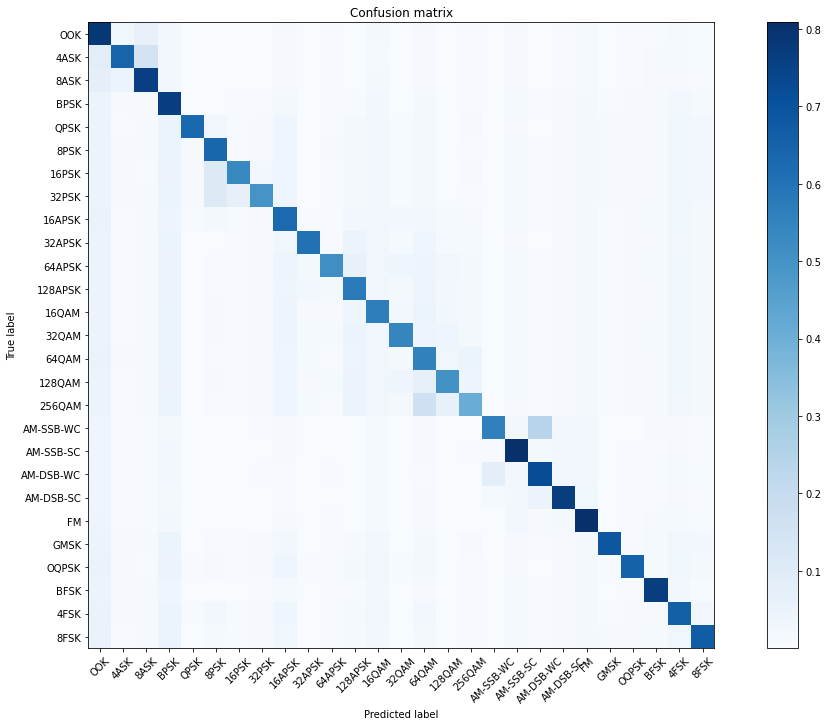

In [20]:
plot_confusion_matrix(confnorm, labels=classes)

### Generate Classification Report

In [21]:
Y_pred = model.predict(X_test,batch_size=batch_size)
y_pred = np.argmax(Y_pred, axis = 1)
y_actual = np.argmax(Y_test, axis = 1)
classificationreport_fp = classification_report(y_actual,y_pred, target_names=mods)
print(classificationreport_fp)

              precision    recall  f1-score   support

         OOK       0.38      0.78      0.51     21160
        4ASK       0.75      0.65      0.69     21398
        8ASK       0.67      0.76      0.71     21053
        BPSK       0.45      0.76      0.56     21127
        QPSK       0.91      0.63      0.75     21449
        8PSK       0.65      0.64      0.64     21423
       16PSK       0.77      0.53      0.63     21566
       32PSK       0.75      0.49      0.60     21322
      16APSK       0.50      0.63      0.56     21333
      32APSK       0.85      0.60      0.71     21126
      64APSK       0.77      0.51      0.62     21264
     128APSK       0.56      0.57      0.57     21316
       16QAM       0.51      0.56      0.53     21271
       32QAM       0.72      0.54      0.62     21374
       64QAM       0.45      0.55      0.49     21356
      128QAM       0.68      0.50      0.58     21252
      256QAM       0.61      0.41      0.49     21068
   AM-SSB-WC       0.81    

Precision Measures the  Accuracy of the positive predictions.
Precision = TP/(TP + FP)

Recall Measures the fraction of positives that were correctly identified.
Recall = TP/(TP+FN)

The F1 score is measure of a weighted harmonic mean of precision and recall. 

Support is the number of values for each class.

Looking at the f1- scores for the different classes, we can see that the model is more accuracte with some classses than others.
For example, the model is not able to correctly identify the hiher order PSK and QAM modulations as other classes.   

### Accuracy vs. SNR
Now lets see how the model accuracy is effcted by SNR.

In [22]:
batchsize = 1024
progress = ProgressBar()
snrlist = np.unique(Z_test)
acc_snr_arr = []

# interate over SNRs
for snr in progress(snrlist):
    acc_arr = []
    i_SNR = np.where(Z_test==snr)
    X_SNR = X_test[i_SNR[0],:,:]
    Y_SNR = Y_test[i_SNR[0],:]
    X_SNR_len = np.shape(X_SNR)[0]
    total_batches = int(X_SNR_len/batchsize)
    
    for i in (range(0, total_batches)):
        x_batch, y_batch = X_SNR[i*batchsize:i*batchsize+batchsize], Y_SNR[i*batchsize:i*batchsize+batchsize]
        
        # model prediction
        pred = model.predict(x_batch)
        
        #Pediction values are onehote, corresponding to indices representing different modulation types
        pred_ind = np.argmax(pred, axis=1)
        expected_ind = np.argmax(y_batch, axis=1)
        matches  = sum(np.equal(pred_ind, expected_ind))
        acc      = matches/batchsize
        acc_arr.append(acc)

    # Average the per-batch accuracy values
    accuracy = np.mean(acc_arr)
    acc_snr_arr.append(accuracy)
    print("SNR: ", snr, "accuracy", accuracy)

  0% (0 of 26) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--2022-05-05 19:23:43.697816: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.89GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-05-05 19:23:43.697906: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.89GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
  3% (1 of 26) |                         | Elapsed Time: 0:00:08 ETA:   0:03:22

SNR:  -20 accuracy 0.03817894345238095


  7% (2 of 26) |#                        | Elapsed Time: 0:00:15 ETA:   0:03:02

SNR:  -18 accuracy 0.04045758928571429


 11% (3 of 26) |##                       | Elapsed Time: 0:00:23 ETA:   0:03:04

SNR:  -16 accuracy 0.042782738095238096


 15% (4 of 26) |###                      | Elapsed Time: 0:00:32 ETA:   0:03:06

SNR:  -14 accuracy 0.057431175595238096


 19% (5 of 26) |####                     | Elapsed Time: 0:00:40 ETA:   0:02:48

SNR:  -12 accuracy 0.08063616071428571


 23% (6 of 26) |#####                    | Elapsed Time: 0:00:48 ETA:   0:02:44

SNR:  -10 accuracy 0.14374069940476192


 26% (7 of 26) |######                   | Elapsed Time: 0:00:56 ETA:   0:02:35

SNR:  -8 accuracy 0.21684337797619047


 30% (8 of 26) |#######                  | Elapsed Time: 0:01:04 ETA:   0:02:24

SNR:  -6 accuracy 0.28813244047619047


 34% (9 of 26) |########                 | Elapsed Time: 0:01:12 ETA:   0:02:10

SNR:  -4 accuracy 0.37253534226190477


 38% (10 of 26) |#########               | Elapsed Time: 0:01:20 ETA:   0:02:04

SNR:  -2 accuracy 0.4884672619047619


 42% (11 of 26) |##########              | Elapsed Time: 0:01:28 ETA:   0:01:57

SNR:  0 accuracy 0.6231863839285714


 46% (12 of 26) |###########             | Elapsed Time: 0:01:35 ETA:   0:01:48

SNR:  2 accuracy 0.7040550595238095


 50% (13 of 26) |############            | Elapsed Time: 0:01:43 ETA:   0:01:43

SNR:  4 accuracy 0.8157552083333334


 53% (14 of 26) |############            | Elapsed Time: 0:01:51 ETA:   0:01:33

SNR:  6 accuracy 0.9073660714285714


 57% (15 of 26) |#############           | Elapsed Time: 0:01:59 ETA:   0:01:24

SNR:  8 accuracy 0.9588448660714286


 61% (16 of 26) |##############          | Elapsed Time: 0:02:05 ETA:   0:01:06

SNR:  10 accuracy 0.9745163690476191


 65% (17 of 26) |###############         | Elapsed Time: 0:02:13 ETA:   0:01:07

SNR:  12 accuracy 0.9813058035714286


 69% (18 of 26) |################        | Elapsed Time: 0:02:21 ETA:   0:01:01

SNR:  14 accuracy 0.9812593005952381


 73% (19 of 26) |#################       | Elapsed Time: 0:02:29 ETA:   0:00:57

SNR:  16 accuracy 0.9814918154761905


 76% (20 of 26) |##################      | Elapsed Time: 0:02:37 ETA:   0:00:47

SNR:  18 accuracy 0.9831194196428571


 80% (21 of 26) |###################     | Elapsed Time: 0:02:45 ETA:   0:00:40

SNR:  20 accuracy 0.9842819940476191


 84% (22 of 26) |####################    | Elapsed Time: 0:02:52 ETA:   0:00:28

SNR:  22 accuracy 0.9839564732142857


 88% (23 of 26) |#####################   | Elapsed Time: 0:02:59 ETA:   0:00:22

SNR:  24 accuracy 0.9815848214285714


 92% (24 of 26) |######################  | Elapsed Time: 0:03:07 ETA:   0:00:15

SNR:  26 accuracy 0.9827473958333334


 96% (25 of 26) |####################### | Elapsed Time: 0:03:15 ETA:   0:00:07

SNR:  28 accuracy 0.9830264136904762


100% (26 of 26) |########################| Elapsed Time: 0:03:22 Time:  0:03:22


SNR:  30 accuracy 0.9828404017857143


<Figure size 72x72 with 0 Axes>

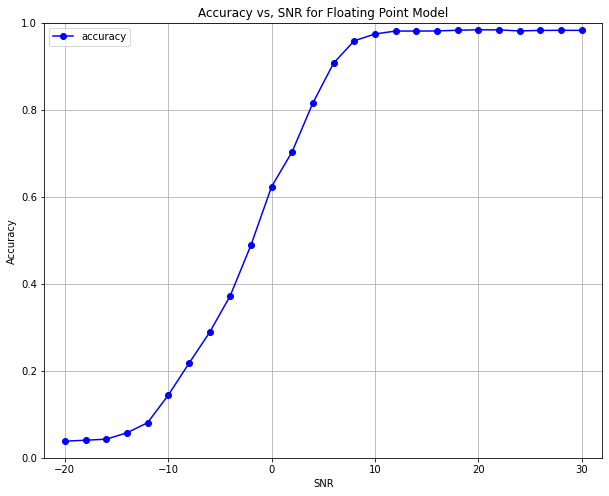

In [23]:
plt.figure(figsize=(1,1))
plt.show()
fig= plt.figure(figsize=(10,8))
plt.plot(snrlist, acc_snr_arr, 'bo-', label='accuracy')
plt.ylabel('Accuracy')
plt.xlabel('SNR')
plt.title("Accuracy vs, SNR for Floating Point Model")
plt.legend()
plt.axis([-22, 32, 0, 1.0])
plt.grid()

Are you can see for SNRs below -10db the Top1 accuracy is no better than a random guess (1/27), and once SNR is above 10db the Top1 accuracy approaches 98%.

## Vitis AI
The Vitis-AI tools will be used the Quantize and Compile the model for accleration on the DPU. <br>
Vitis-AI 2.0 natively supports keras in TensorFlow2, and we can directly read in the .h5 model. 

## Quantize Model to INT8
The Vitis-AI Quantizer uses a  small set of unlabeled samples to analyze the distribution of the activations. We will use 1000 input samples from the test set. <br>

The quantized.h5 model that is produced will be used as input to the Vitis-AI Quantizer

In [24]:
# reload the model in case it was closed
!ls -l fp_model/
model = tf.keras.models.load_model('fp_model/resnet_fp_model.h5')
 
from tensorflow_model_optimization.quantization.keras import vitis_quantize
quantizer = vitis_quantize.VitisQuantizer(model)
quantized_model = quantizer.quantize_model(calib_dataset = X_test[1:1000])

# Save the model
!mkdir -p quantize_results
quantized_model.save('quantize_results/quantized_model.h5')
!ls -l quantize_results

total 5816
-rw-r--r-- 1 vitis-ai-user vitis-ai-group 5955104 May  5 19:22 resnet_fp_model.h5


/opt/vitis_ai/conda/envs/vitis-ai-tensorflow2/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


[VAI INFO] Update custom_layer_type: []
[VAI INFO] Start CrossLayerEqualization...
10/10 [==============================] - 2s 267ms/step
[VAI INFO] CrossLayerEqualization Done.
[VAI INFO] Start Quantize Calibration...
32/32 [==============================] - 10s 83ms/step
[VAI INFO] Quantize Calibration Done.
[VAI INFO] Start Post-Quantize Adjustment...
[VAI INFO] Post-Quantize Adjustment Done.
[VAI INFO] Quantization Finished.
total 5548
-rw-r--r-- 1 vitis-ai-user vitis-ai-group 2639712 Dec 21 13:27 fine_tuned_model.h5
-rw-r--r-- 1 vitis-ai-user vitis-ai-group 3035344 May  5 19:27 quantized_model.h5


### Load and Compile Model for Evaluation
We can now load and recompile the INT8 model and run evaluations to compare with the floating point model

### Evalute  Model INT8 Performance

In [25]:
# load quantized model
from tensorflow_model_optimization.quantization.keras import vitis_quantize
with vitis_quantize.quantize_scope():
  q_model = tf.keras.models.load_model('quantize_results/quantized_model.h5')

q_model.compile(loss='categorical_crossentropy', metrics=["accuracy"])

score = q_model.evaluate(X_test, Y_test,  verbose=0, batch_size=1024)
print(score)

[1.1745120286941528, 0.6344501972198486]


The Overall Top-1 score has gone down by about .4% due to quantization

### Classification Report for INT8 Model

In [26]:
batch_size = 128
Y_pred = q_model.predict(X_test,batch_size=batch_size)
y_pred = np.argmax(Y_pred, axis = 1)
y_actual = np.argmax(Y_test, axis = 1)
classificationreport_int8 = classification_report(y_actual,y_pred, target_names=mods)
print(classificationreport_int8)

              precision    recall  f1-score   support

         OOK       0.27      0.83      0.41     21160
        4ASK       0.70      0.67      0.68     21398
        8ASK       0.73      0.72      0.72     21053
        BPSK       0.31      0.80      0.44     21127
        QPSK       0.68      0.65      0.67     21449
        8PSK       0.60      0.64      0.62     21423
       16PSK       0.72      0.54      0.62     21566
       32PSK       0.93      0.47      0.62     21322
      16APSK       0.58      0.62      0.60     21333
      32APSK       0.57      0.65      0.61     21126
      64APSK       0.67      0.52      0.59     21264
     128APSK       0.56      0.56      0.56     21316
       16QAM       0.89      0.54      0.67     21271
       32QAM       0.76      0.53      0.63     21374
       64QAM       0.63      0.54      0.58     21356
      128QAM       0.78      0.49      0.60     21252
      256QAM       0.85      0.38      0.53     21068
   AM-SSB-WC       0.71    

### Accuracy vs SNR for INT8 Model

In [27]:
batchsize = 128
progress = ProgressBar()
snrlist = np.unique(Z_test)
acc_snr_arr = []

# interate over SNRs
for snr in progress(snrlist):
    acc_arr = []
    i_SNR = np.where(Z_test==snr)
    X_SNR = X_test[i_SNR[0],:,:]
    Y_SNR = Y_test[i_SNR[0],:]
    X_SNR_len = np.shape(X_SNR)[0]
    total_batches = int(X_SNR_len/batchsize)
    
    for i in (range(0, total_batches)):
        x_batch, y_batch = X_SNR[i*batchsize:i*batchsize+batchsize], Y_SNR[i*batchsize:i*batchsize+batchsize]
        
        # model prediction
        pred = q_model.predict(x_batch)
        
        #Pediction values are 0-24, corresponding to indices representing different modulation types
        pred_ind = np.argmax(pred, axis=1)
        expected_ind = np.argmax(y_batch, axis=1)
        matches  = sum(np.equal(pred_ind, expected_ind))
        acc      = matches/batchsize
        acc_arr.append(acc)

    # Average the per-batch accuracy values
    accuracy = np.mean(acc_arr)
    acc_snr_arr.append(accuracy)
    print("SNR: ", snr, "accuracy", accuracy)

  3% (1 of 26) |                         | Elapsed Time: 0:00:18 ETA:   0:07:47

SNR:  -20 accuracy 0.03733648255813953


  7% (2 of 26) |#                        | Elapsed Time: 0:00:36 ETA:   0:07:00

SNR:  -18 accuracy 0.0398753612716763


 11% (3 of 26) |##                       | Elapsed Time: 0:00:53 ETA:   0:06:29

SNR:  -16 accuracy 0.04387718023255814


 15% (4 of 26) |###                      | Elapsed Time: 0:01:10 ETA:   0:06:23

SNR:  -14 accuracy 0.05686773255813953


 19% (5 of 26) |####                     | Elapsed Time: 0:01:28 ETA:   0:06:06

SNR:  -12 accuracy 0.07857921511627906


 23% (6 of 26) |#####                    | Elapsed Time: 0:01:45 ETA:   0:05:49

SNR:  -10 accuracy 0.13453851744186046


 26% (7 of 26) |######                   | Elapsed Time: 0:02:03 ETA:   0:05:34

SNR:  -8 accuracy 0.203757225433526


 30% (8 of 26) |#######                  | Elapsed Time: 0:02:21 ETA:   0:05:23

SNR:  -6 accuracy 0.2741642441860465


 34% (9 of 26) |########                 | Elapsed Time: 0:02:37 ETA:   0:04:46

SNR:  -4 accuracy 0.36239035087719296


 38% (10 of 26) |#########               | Elapsed Time: 0:02:55 ETA:   0:04:40

SNR:  -2 accuracy 0.49223265895953755


 42% (11 of 26) |##########              | Elapsed Time: 0:03:12 ETA:   0:04:21

SNR:  0 accuracy 0.6238644622093024


 46% (12 of 26) |###########             | Elapsed Time: 0:03:30 ETA:   0:04:01

SNR:  2 accuracy 0.698264898255814


 50% (13 of 26) |############            | Elapsed Time: 0:03:47 ETA:   0:03:42

SNR:  4 accuracy 0.8077131502890174


 53% (14 of 26) |############            | Elapsed Time: 0:04:04 ETA:   0:03:31

SNR:  6 accuracy 0.8991148843930635


 57% (15 of 26) |#############           | Elapsed Time: 0:04:22 ETA:   0:03:14

SNR:  8 accuracy 0.9535337936046512


 61% (16 of 26) |##############          | Elapsed Time: 0:04:39 ETA:   0:02:53

SNR:  10 accuracy 0.9735368497109826


 65% (17 of 26) |###############         | Elapsed Time: 0:04:57 ETA:   0:02:36

SNR:  12 accuracy 0.979577850877193


 69% (18 of 26) |################        | Elapsed Time: 0:05:14 ETA:   0:02:18

SNR:  14 accuracy 0.9802174707602339


 73% (19 of 26) |#################       | Elapsed Time: 0:05:32 ETA:   0:02:04

SNR:  16 accuracy 0.9815014367816092


 76% (20 of 26) |##################      | Elapsed Time: 0:05:50 ETA:   0:01:45

SNR:  18 accuracy 0.9821039244186046


 80% (21 of 26) |###################     | Elapsed Time: 0:06:08 ETA:   0:01:30

SNR:  20 accuracy 0.9827398255813954


 84% (22 of 26) |####################    | Elapsed Time: 0:06:25 ETA:   0:01:09

SNR:  22 accuracy 0.9827852470930233


 88% (23 of 26) |#####################   | Elapsed Time: 0:06:43 ETA:   0:00:52

SNR:  24 accuracy 0.9811954941860465


 92% (24 of 26) |######################  | Elapsed Time: 0:07:00 ETA:   0:00:35

SNR:  26 accuracy 0.9821749281609196


 96% (25 of 26) |####################### | Elapsed Time: 0:07:17 ETA:   0:00:17

SNR:  28 accuracy 0.981304190751445


100% (26 of 26) |########################| Elapsed Time: 0:07:35 Time:  0:07:35


SNR:  30 accuracy 0.9825932017543859


<Figure size 72x72 with 0 Axes>

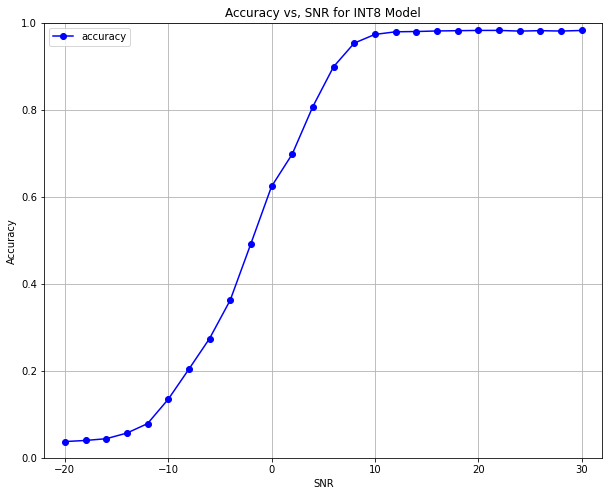

In [28]:
plt.figure(figsize=(1,1))
plt.show()
fig= plt.figure(figsize=(10,8))
plt.plot(snrlist, acc_snr_arr, 'bo-', label='accuracy')
plt.ylabel('Accuracy')
plt.xlabel('SNR')
plt.title("Accuracy vs, SNR for INT8 Model")
plt.legend()
plt.axis([-22, 32, 0, 1.0])
plt.grid()

The Accuracy vs SNR looks very similar to the floating point model.

## Compile Model for DPU
The Vitis-AI compiler reads in the quantized model and generates an xmodel file which the instruction set for the Xilinx Deep Learning Processor (DPU). The arhictecture option (-a) is used to specify a json file which indicates which hw target the DPU is being compiled for.

In [29]:
# Select HW Target Choose Either Quantized or QAT (Fine Tuned Model)

#For kv260
#!vai_c_tensorflow2 -m /workspace/files/quantize_results/quantized_model.h5 -a /opt/vitis_ai/compiler/arch/DPUCZDX8G/KV260/arch.json -o vai_c_output -n rfClassification

#For ZCU104
!vai_c_tensorflow2 -m /workspace/files/quantize_results/quantized_model.h5 -a /opt/vitis_ai/compiler/arch/DPUCZDX8G/ZCU104/arch.json -o vai_c_output -n rfClassification

#For ZCU102 
#!vai_c_tensorflow2 -m /workspace/files/quantize_results/quantized_model.h5 -a /opt/vitis_ai/compiler/arch/DPUCZDX8G/ZCU102/arch.json -o vai_c_output -n rfClassification --options "{'cpu_arch':'arm64', 'mode':'normal', 'save_kernel':''}"

#For Alveo U50
#!vai_c_tensorflow2 -m /workspace/files/quantize_results/quantized_model.h5 -a /opt/vitis_ai/compiler/arch/DPUCAHX8H/U50/arch.json -o vai_c_output -n rfClassification --options "{'cpu_arch':'arm64', 'mode':'normal', 'save_kernel':''}"

#For Alveo U50
#!vai_c_tensorflow2 -m /workspace/files/quantize_results/quantized_model.h5 -a /opt/vitis_ai/compiler/arch/DPUCAHX8H/U50/arch.json -o vai_c_output -n rfClassification --options "{'cpu_arch':'arm64', 'mode':'normal', 'save_kernel':''}"

#For Alveo U250
#!vai_c_tensorflow2 -m /workspace/files/quantize_results/quantized_model.h5 -a /opt/vitis_ai/compiler/arch/DPUCADF8H/U250/arch.json -o vai_c_output -n rfClassification --options "{'cpu_arch':'arm64', 'mode':'normal', 'save_kernel':''}"

#For Versal VCK190
#!vai_c_tensorflow2 -m /workspace/files/quantize_results/quantized_model.h5 -a /opt/vitis_ai/compiler/arch/DPUCVDX8G/VCK190/arch.json -o vai_c_output -n rfClassification --options "{'cpu_arch':'arm64', 'mode':'normal', 'save_kernel':''}"

**************************************************
* VITIS_AI Compilation - Xilinx Inc.
**************************************************
[INFO] Namespace(batchsize=1, inputs_shape=None, layout='NHWC', model_files=['/workspace/files/quantize_results/quantized_model.h5'], model_type='tensorflow2', named_inputs_shape=None, out_filename='/tmp/rfClassification_org.xmodel', proto=None)
[INFO] tensorflow2 model: /workspace/files/quantize_results/quantized_model.h5
[INFO] keras version: 2.6.0
[INFO] Tensorflow Keras model type: functional
[INFO] generate xmodel     :100%|█| 57/57 [00:00<00:00, 2701.57it/s]            
[INFO] dump xmodel: /tmp/rfClassification_org.xmodel
[UNILOG][INFO] Compile mode: dpu
[UNILOG][INFO] Debug mode: function
[UNILOG][INFO] Target architecture: DPUCZDX8G_ISA0_B4096_MAX_BG2
[UNILOG][INFO] Graph name: model, with op num: 103
[UNILOG][INFO] Begin to compile...
[UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
[UNILOG][INFO] Compile done.
[UNILOG][

## Generate Graph Visualization with xir tool.
You will see a compiler message about the number of  subgraphs:
Total device subgraph number 3, DPU subgraph number 1 <br>
This means that are 3 subgraphs created, 1 for the input layer, 1 for for everything up the softmax layer (which runs on the DPU), and one for the softmax. <br>

The softmax layer can  optionally be acclerated in programmable logic, however in this tutorial we will implement the softmax layer on the CPU.

You can use the the xir command generate a .png file to visulize the graph layers.

In [30]:
!xir png /workspace/files/vai_c_output/rfClassification.xmodel xmodel.png

### Write out  samples  of Test Data to be used later for HW testing
The python function we will run in the target board will read in these numpy files containing the RF data, class, and SNR.

In [31]:
np.save('/workspace/rf_input.npy', X_test[0:1000,:,:])
np.save('/workspace/rf_classes.npy', Y_test[0:1000])
np.save('/workspace/rf_snrs.npy', Z_test[0:1000])

Now that a dpu xmodel file has been created you are ready to run on target board. You will need to copy the above 3 files, and the xmodel file from the compiler to your target board.

You can close this notebook by entering CtrlC at the console, close the docker container by entering CtrlD, and the proceed with the Tutorial readme instructions.